# Imports

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
import scipy.stats as stats
import matplotlib.gridspec as gridspec
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, kpss, bds
import warnings
warnings.filterwarnings("ignore")

In [2]:
# df = Dataframe with an index and a value column
# title = Title of data being used
# xlab = Label of df.index
# ylab = Label of df.values
# seasonal_periods = The repetition cycle

TS_str = ['TS (N, N)', 'TS (A, N)', 'TS (Ad, N)', 'TS (N, A)', 'TS (A, A)', 'TS (Ad, A)', 'TS (N, M)', 'TS (A, M)', 'TS (Ad, M)']
TS_print = []
previousStepsToShow = 15;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
#df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
#df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
#title = 'CPIAUC'
# Label of df.index
#xlab = 'Months/Year'; 
# Label of df.values
#ylab = 'CPI: Index 1982-1984=100 (Seasonally Adjusted)';
#seasonal_periods = 12

stepsToForecast = [1, 5, 21];
df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
df = pd.DataFrame(df, columns= ['Date','Close'])
df.set_index('Date', drop=True, inplace=True)
df.index = pd.to_datetime(df.index)
df = df.truncate(before='2002-01-01', after='2019-09-27')
df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
title = 'PSI20: Historical Closing Prices'
xlab = 'Working Days/Year'; 
ylab = 'Closing Price (Euro)';
seasonal_periods = 5

#stepsToForecast = [1, 5, 21];
#df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'SP500'
#xlab = 'Days/Year'; 
#ylab = 'Closing Price ($)';
#seasonal_periods=5;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
#df_train = df[['TRFVOLUSM227NFWA']][:-stepsToForecast[-1]].rename(columns={'TRFVOLUSM227NFWA': 'train'})
#df_test = df[['TRFVOLUSM227NFWA']][-stepsToForecast[-1]:].rename(columns={'TRFVOLUSM227NFWA': 'test'})
#title = "Vehicle Miles Traveled";
#xlab = "Months/Year";
#ylab = "Millions of Miles";
#seasonal_periods = 12

# Define functions

In [3]:
def printMAEpred(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    ape = 100*(abs(y_pred - y_true.T) / y_true.T);
    for i in horizonSteps:
        print('Prediction for ' + str(i) + ' step: MAE = ' + str(round(np.mean(ae[0,:i]), 2)) + ' (' + str(round(np.mean(ape[0,:i]), 2)) + '%)'  )

In [4]:
def ETSplot(train, test, fit, forecast, title, xlab=xlab, ylab=ylab, previousStepsToShow=previousStepsToShow, stepsToForecast = stepsToForecast):
    plt.figure(figsize=(20,7))
    labels = ['Training and testing data', 'Fitted values', 'Predicted values']
    plt.title(title)
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, train[-previousStepsToShow:], 'k', linewidth = 3 )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, fit[-previousStepsToShow-1:-1], 'b--' , linewidth = 2 )
    plt.plot(1+np.arange(stepsToForecast[-1]), forecast, 'r--*' , linewidth = 2 )
    plt.plot(1+np.arange(stepsToForecast[-1]), test, 'k-o' , linewidth = 3 )
    plt.legend(labels, loc='upper left')
    plt.grid(color='k', linestyle='--', linewidth=.2)
    plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
    plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
    plt.xlabel('Past and future working days')
    plt.ylabel(ylab)
    plt.show()

    printMAEpred(test, forecast, stepsToForecast)

## Assess stationarity (mean and variance)

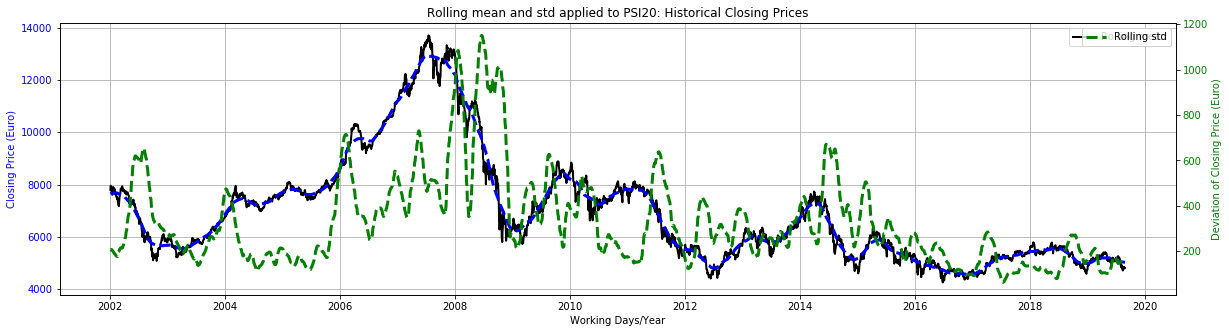

In [5]:
# Let's visually assess data stationarity through rolling mean and std
#However, note that ETS models do not rely on stationary data, contrarily to ARIMAs
rolling_window = 100
rolling_mean = df_train.rolling(rolling_window, center=True, min_periods=1).mean() 
rolling_std  = df_train.rolling(rolling_window, center=True, min_periods=1).std() 

fig, axMean = plt.subplots(figsize=(20,5))

axMean.plot(df_train.index, df_train.values, label = df_train.columns.values[0], linewidth=2, color='black')
axMean.plot(rolling_mean, label='Rolling mean', linestyle='--', linewidth=3, color='blue')
axMean.set_xlabel(xlab)
axMean.legend(['Rolling mean'], loc='best')
axMean.set_ylabel(ylab, color='blue')
axMean.tick_params(axis='y', labelcolor='blue')

axStd = axMean.twinx()
axStd.plot(rolling_std, label='Rolling std', linestyle='--', linewidth=3, color='green')
axStd.set_ylabel(ylab)
axStd.legend(['Rolling std'], loc='best')
axStd.set_ylabel('Deviation of ' + ylab, color='green')
axStd.tick_params(axis='y', labelcolor='green')

axMean.set_title('Rolling mean and std applied to ' + title)
axMean.grid()
plt.show()

# Model Forecast

## Single Exponential Smoothing

#### TS (N, N) - Simple Exponential Smoothing

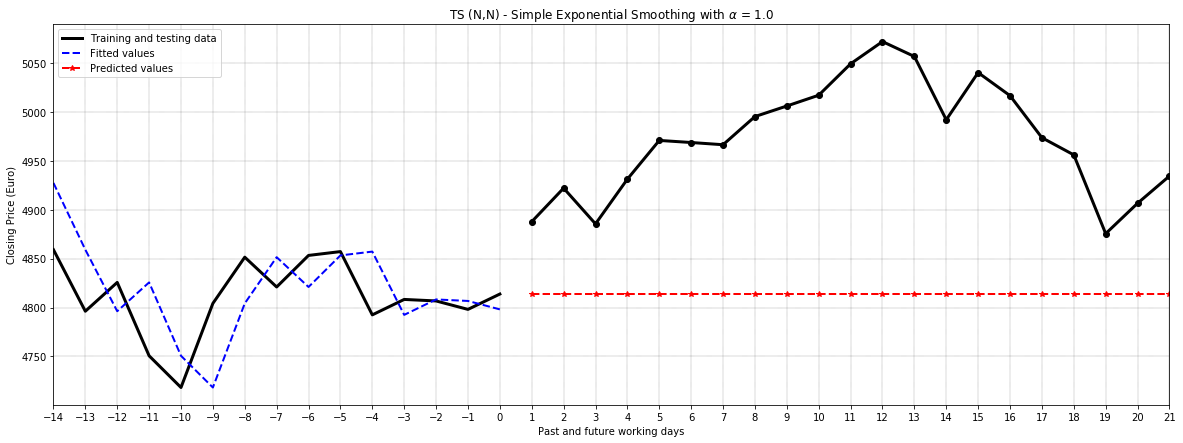

Prediction for 1 step: MAE = 73.89 (1.51%)
Prediction for 5 step: MAE = 105.6 (2.14%)
Prediction for 21 step: MAE = 158.61 (3.18%)


In [6]:
model_TS_NN = ExponentialSmoothing(df_train.values, 
                                   trend=None, 
                                   damped=False,
                                   seasonal=None)
TS_NN = model_TS_NN.fit(smoothing_level=None)

if (TS_NN.mle_retvals.success):
    TS_NN_forecast = TS_NN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_NN_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N,N) - Simple Exponential Smoothing with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NN.params['smoothing_level'],2))
           
        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_NN.fittedfcast, 
                forecast = TS_NN_forecast, 
                title = title)
        
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

## Double Exponential Smoothing

#### TS (A, N) - Holt’s linear method

In [ ]:
model_TS_AN = ExponentialSmoothing(df_train.values, 
                                   trend='add', 
                                   damped=False,
                                   seasonal=None)
TS_AN = model_TS_AN.fit(smoothing_level=None, 
                        smoothing_slope=None)

if (TS_AN.mle_retvals.success):
    TS_AN_forecast = TS_AN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AN_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (A,N) - Holts linear method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AN.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AN.params['smoothing_slope'],2))

        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_AN.fittedfcast, 
                forecast = TS_AN_forecast, 
                title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

#### TS (Ad, N) - Additive damped trend method

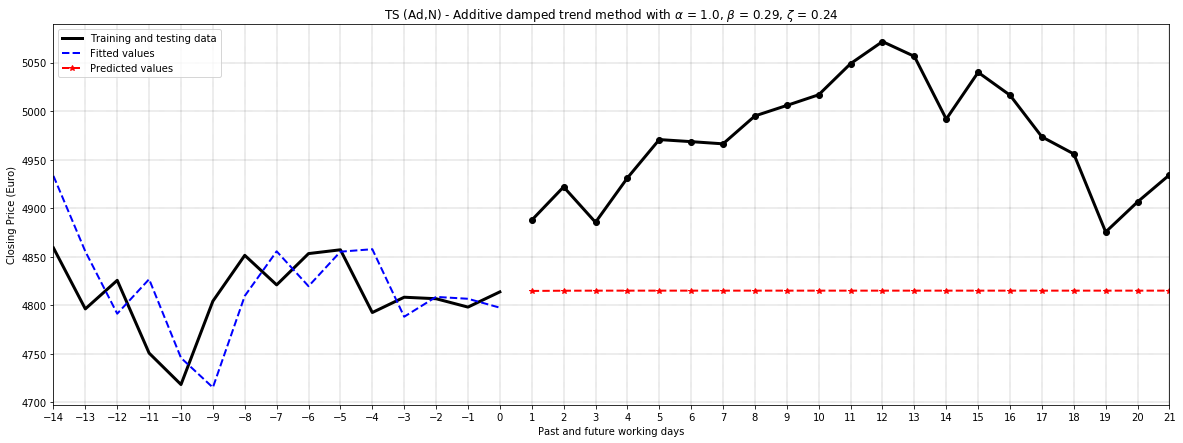

Prediction for 1 step: MAE = 72.92 (1.49%)
Prediction for 5 step: MAE = 104.4 (2.12%)
Prediction for 21 step: MAE = 157.36 (3.15%)


In [9]:
model_TS_AdN = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True,
                                    seasonal=None)
TS_AdN = model_TS_AdN.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None)

if (TS_AdN.mle_retvals.success):
    TS_AdN_forecast = TS_AdN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdN_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad,N) - Additive damped trend method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdN.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AdN.params['smoothing_slope'],2)) \
            + r', $\zeta$' + ' = ' + str(round(TS_AdN.params['damping_slope'],2))

        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_AdN.fittedfcast, 
                forecast = TS_AdN_forecast, 
                title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

## Triple Exponential Smoothing

#### TS (N, A) method

In [10]:
model_TS_NA = ExponentialSmoothing(df_train.values, 
                                   trend=None, 
                                   damped=False, 
                                   seasonal='add', 
                                   seasonal_periods=seasonal_periods)
TS_NA = model_TS_NA.fit(smoothing_level=None, 
                        smoothing_seasonal=None)

if (TS_NA.mle_retvals.success):
    TS_NA_forecast = TS_NA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_NA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N, A) with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NA.params['smoothing_level'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_NA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_NA.seasonal_periods);

        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_NA.fittedfcast, 
                forecast = TS_NA_forecast, 
                title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

#### TS (A, A) - Additive Holt-Winters method

In [ ]:
model_TS_AA = ExponentialSmoothing(df_train.values, 
                                   trend='add', 
                                   damped=False, 
                                   seasonal='add', 
                                   seasonal_periods=seasonal_periods)
TS_AA = model_TS_AA.fit(smoothing_level=None, 
                        smoothing_slope=None, 
                        smoothing_seasonal=None)

if (TS_AA.mle_retvals.success):
    TS_AA_forecast = TS_AA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad, A) - Additive Holt-Winters method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AA.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AA.params['smoothing_slope'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_AA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_AA.fittedfcast, 
                forecast = TS_AA_forecast, 
                title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

#### TS (Ad, A) method

In [ ]:
model_TS_AdA = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True, 
                                    seasonal='add', 
                                    seasonal_periods=seasonal_periods)
TS_AdA = model_TS_AdA.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None, 
                          smoothing_seasonal=None)

if (TS_AdA.mle_retvals.success):
    TS_AdA_forecast = TS_AdA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad, A) method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdA.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AdA.params['smoothing_slope'],2)) \
            + r', $\zeta$' + ' = ' + str(round(TS_AdA.params['damping_slope'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_AdA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_AdA.fittedfcast, 
                forecast = TS_AdA_forecast, 
                title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

#### TS (N, M) method

In [ ]:
model_TS_NM = ExponentialSmoothing(df_train.values, 
                                    trend=None, 
                                    damped=False, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_NM = model_TS_NM.fit(smoothing_level=None,  
                          smoothing_seasonal=None)

if (TS_NM.mle_retvals.success):
    TS_NM_forecast = TS_NM.forecast(stepsToForecast[-1])
    
    if (~np.isnan(TS_NM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N, M) method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NM.params['smoothing_level'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_NM.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_NM.fittedfcast, 
                forecast = TS_NM_forecast, 
                title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

#### TS (A, M) Multiplicative Holt-Winters’ method

In [ ]:
model_TS_AM = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=False, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_AM = model_TS_AM.fit(smoothing_level=None, 
                        smoothing_slope=None, 
                        smoothing_seasonal=None)

if (TS_AM.mle_retvals.success):
    TS_AM_forecast = TS_AM.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (A, M) Multiplicative Holt-Winters method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AA.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AA.params['smoothing_slope'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_AA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_AM.fittedfcast, 
                forecast = TS_AM_forecast, 
                title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

#### TS (Ad, M) Holt-Winters’ damped method

In [ ]:
model_TS_AdM = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_AdM = model_TS_AdM.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None, 
                          smoothing_seasonal=None)

if (TS_AdM.mle_retvals.success):
    TS_AdM_forecast = TS_AdM.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad, M) Holt-Winters damped method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdM.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AdM.params['smoothing_slope'],2)) \
            + r', $\zeta$' + ' = ' + str(round(TS_AdM.params['damping_slope'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_AdM.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AdM.seasonal_periods);

        ETSplot(train = df_train.values, 
                test = df_test.values, 
                fit = TS_AdM.fittedfcast, 
                forecast = TS_AdM_forecast, 
                title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

## Model Selection

#### Akaike Information Criteria (AIC) and Bayesian Information Criteria (BIC)

In [ ]:
plt.figure(figsize=(20,10))

params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)

TS = [TS_NN, TS_AN, TS_AdN, TS_NA, TS_AA, TS_AdA, TS_NM, TS_AM, TS_AdM]

spacing = 0.05
barWidth = 0.1
r = np.arange(len(TS)) - (len(TS)/2)*spacing

plt.subplot(211)
TS_val = []
for i in np.arange(len(TS)):
    if(TS_print[i]):
        plt.bar(r[i], TS[i].aic,  width=barWidth, edgecolor='white', label=TS_str[i])
        TS_val.append(TS[i].aic)
plt.axis((r[0]-.3, r[8]+.3, min(TS_val)-0.1*(max(TS_val)-min(TS_val)), max(TS_val)+0.1*(max(TS_val)-min(TS_val))))
plt.xticks(r, TS_str, fontsize='16')
plt.title('Aikake Information Criteria for TS models (that achieved convergence)')
plt.grid()

plt.subplot(212)
TS_val = []
for i in np.arange(len(TS)):
    if(TS_print[i]):
        plt.bar(r[i], TS[i].bic,  width=barWidth, edgecolor='white', label=TS_str[i])
        TS_val.append(TS[i].bic)
plt.axis((r[0]-.3, r[8]+.3, min(TS_val)-0.1*(max(TS_val)-min(TS_val)), max(TS_val)+0.1*(max(TS_val)-min(TS_val))))
plt.xticks(r, TS_str, fontsize='16')
plt.title('Bayesian Information Criteria for TS models (that achieved convergence)')
plt.grid()

## Model Comparison

In [ ]:
# Select from 
# TS_str = ['TS (N, N)', 'TS (A, N)', 'TS (Ad, N)', 
#           'TS (N, A)', 'TS (A, A)', 'TS (Ad, A)', 
#           'TS (N, M)', 'TS (A, M)', 'TS (Ad, M)']
TS_labels = ['Train and Test data', 
             'TS (N, N)',
             'TS (Ad, A)',
             'TS (Ad, M)']
plt.figure(figsize=(20,7))
plt.title('Exponential Smoothing models comparison')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3, label='Training and testing data')
plt.legend(TS_labels, loc='upper left')
for i in np.arange(len(TS_labels)-1):
    etsPlot = plt.plot(1+np.arange(stepsToForecast[-1]), TS[TS_str.index(TS_labels[i+1])].forecast(stepsToForecast[-1]), '--*' , linewidth = 3, label = TS_labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, TS[TS_str.index(TS_labels[i+1])].fittedfcast[-previousStepsToShow-1:-1], '--' , linewidth = 3, color=etsPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 )
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future samples')
plt.ylabel(ylab)
plt.show()

In [ ]:
for i in np.arange(len(TS_labels)-1):
    print(TS_labels[i+1])
    printMAEpred(df_test.values, TS[TS_str.index(TS_labels[i+1])].forecast(stepsToForecast[-1]), stepsToForecast)
    print(" ")

## Model Validation

In [ ]:
# Pick you favourite's models order
TS_model = 'TS (Ad, M)'

model_fit = TS[TS_str.index(TS_model)]
df_res = pd.DataFrame({"resid": model_fit.resid}, index= df_train.index)
model_fit.summary()

In [ ]:
# Plot model residuals
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title(TS_model +' Residuals')
plt.grid()

In [ ]:
# Plot histogram
plt.figure(figsize=(10,5))
plt.title(TS_model + ' Residuals (Histogram)')
hist_res = df_res['resid'].hist(bins=50, normed=1, edgecolor='black')
df_res['resid'].plot(kind='kde', linewidth=2, linestyle='--')
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.8, r'$\mu = $'+ str(round(np.mean(df_res), 6)))
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.75, r'$\sigma^2 = $' + str(round(np.var(df_res), 6)))
plt.xlabel('Residuals')
limX = np.mean(df_res.values)+5*np.std(df_res.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

In [ ]:
print ("Mean: %.6f" % np.mean(df_res))
print ("Variance: %.6f" % np.var(df_res))

### Normality Test

In [ ]:
k, kpval = kurtosistest(df_res['resid'].values)
kurtosis_val = kurtosis(df_res['resid'].values, fisher=True)
# If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)
print(" ")

s, spval = skewtest(df_res['resid'].values)
skew_val = skew(df_res['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 
print(" ")

jb, jbpval= stats.jarque_bera(df_res['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print(" ")

ks, kspval = stats.kstest(df_res['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

### Engle\'s Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [ ]:
lm, lmpval, fval, fpval = het_arch(df_res['resid'].values)
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')

print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)
print('')

### Test for No Autocorrelation

#### Brock–Dechert–Scheinkman test

In [ ]:
# Computing BDS
# Tests independent and identically distributed (i.i.d.) time series
result = bds(df_res['resid'].values, max_dim=6);
print("BDS Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

#### Box-Pierce test

In [ ]:
maxLags = 21
lbvalue, pvalue, bpvalue, bppvalue = acorr_ljungbox(df_res['resid'].values, lags = range(1, maxLags), boxpierce=True)
df_boxpierce = pd.DataFrame({'lags':range(1, maxLags), 'bp statistic': bpvalue, 'p-value':bppvalue})
print(df_boxpierce[['lags', 'bp statistic', 'p-value']].to_string(index = False))

#### Ljung-Box test

In [ ]:
df_ljungbox = pd.DataFrame({'lags':range(1, maxLags), 'lb statistic': bpvalue, 'p-value':pvalue})
print(df_ljungbox[['lags', 'lb statistic', 'p-value']].to_string(index = False))

In [ ]:
qqplot(df_res['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()

In [ ]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));

In [7]:
TS_NN_forecast

array([4813.74, 4813.74, 4813.74, 4813.74, 4813.74, 4813.74, 4813.74,
       4813.74, 4813.74, 4813.74, 4813.74, 4813.74, 4813.74, 4813.74,
       4813.74, 4813.74, 4813.74, 4813.74, 4813.74, 4813.74, 4813.74])